# Get Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/colab/NLP/stack_overflow_tag_prediction/data.zip" .
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/text_prepare_tests.tsv  
  inflating: data/train.tsv          
  inflating: data/test.tsv           
  inflating: data/validation.tsv     


# Imports

In [3]:
import os, re
import pickle
import numpy as np
import pandas as pd

from ast import literal_eval

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [4]:
import nltk

nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Data Analysis

In [6]:
df_train=pd.read_csv("/content/data/train.tsv", sep='\t')
df_train.head()

,title,tags
0,How to draw a stacked dotplot in R?,['r']
1,mysql select all records where a datetime fiel...,"['php', 'mysql']"
2,How to terminate windows phone 8.1 app,['c#']
3,get current time in a specific country via jquery,"['javascript', 'jquery']"
4,Configuring Tomcat to Use SSL,['java']


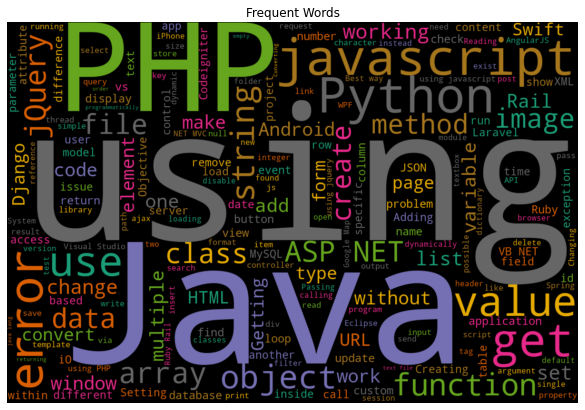

In [7]:
# display frequent words 

def visualize_wordcloud(df, title):
  data = df['title'] #.to_list()
  data =" ".join([text.strip() for text in data ] )

  stopword_ll = set(stopwords.words("english"))

  plt.figure(figsize=(15,7))
  wc = WordCloud(width=1200, height=800, max_words=200, stopwords=stopword_ll, colormap="Dark2").generate(data)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title(title)
  plt.show() 


visualize_wordcloud(df_train, "Frequent Words")

In [8]:
def get_tags_info(df):
  tags_list=[]

  for tags in df["tags"]:
    tg_ll=literal_eval(tags)
    tags_list+=tg_ll

  unique_tags, tags_count=np.unique(tags_list, return_counts=True)

  return tags_list, (unique_tags, tags_count)

tags_list, (unique_tags, tags_count) = get_tags_info(df_train)

In [9]:
# view all tags

L=len(unique_tags)
n=10

for i in range(0, L, n):
  j=min(i+n, L)
  tag_ll=unique_tags[i:j].tolist()
  print(tag_ll)


['.net', 'ajax', 'algorithm', 'android', 'angularjs', 'apache', 'arrays', 'asp.net', 'asp.net-mvc', 'c']
['c#', 'c++', 'class', 'cocoa-touch', 'codeigniter', 'css', 'csv', 'database', 'date', 'datetime']
['django', 'dom', 'eclipse', 'entity-framework', 'excel', 'facebook', 'file', 'forms', 'function', 'generics']
['google-maps', 'hibernate', 'html', 'html5', 'image', 'ios', 'iphone', 'java', 'javascript', 'jquery']
['json', 'jsp', 'laravel', 'linq', 'linux', 'list', 'loops', 'maven', 'mongodb', 'multithreading']
['mysql', 'node.js', 'numpy', 'objective-c', 'oop', 'opencv', 'osx', 'pandas', 'parsing', 'performance']
['php', 'pointers', 'python', 'python-2.7', 'python-3.x', 'qt', 'r', 'regex', 'rest', 'ruby']
['ruby-on-rails', 'ruby-on-rails-3', 'selenium', 'servlets', 'session', 'sockets', 'sorting', 'spring', 'spring-mvc', 'sql']
['sql-server', 'string', 'swift', 'swing', 'twitter-bootstrap', 'uitableview', 'unit-testing', 'validation', 'vb.net', 'visual-studio']
['visual-studio-2010',

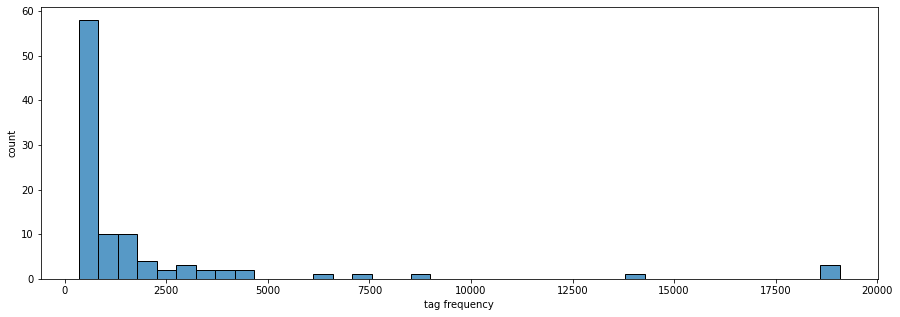

In [10]:
# tags frequency distribution in dataset

plt.figure(figsize=(15,5))

sns.histplot(tags_count); 
plt.xlabel("tag frequency")
plt.ylabel("count")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


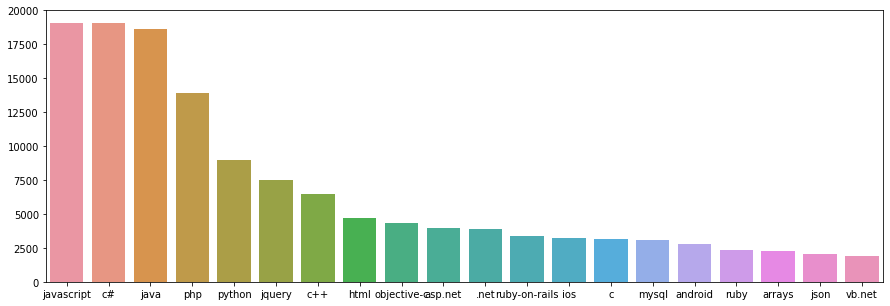

In [11]:
# Get top N tags in dataset

N=20

count_sort_ind = np.argsort(-tags_count)
tags_ll2=unique_tags[count_sort_ind][:N]
count_ll2=tags_count[count_sort_ind][:N]

plt.figure(figsize=(15,5))
sns.barplot(tags_ll2, count_ll2 )
plt.show()

# Data Preprocess

In [12]:
# processing text to cleaned data

def clean_text(text):
  text=re.sub(r'[^\x00-\x7F]+',' ', text)                     # remove non-ascii characters
  text=re.sub(r'[^\w ]', '', text)                            # remove non-words ; \x01 \x08
  text=re.sub("['`_\"]", " ", text)                           # "beta'''" -> "beta"
  text=re.sub("[0-9]+(/|\-)[0-9]+(/|\-)[0-9]+", " ", text)    # 22/05/2015 22-05-2015 -> " "

  return text


def stopwords_removal(tokenized_text):  
  tokenized_text_2=tokenized_text.copy()

  sw=stopwords.words('english')
  for word in tokenized_text:
    if word in sw:
      tokenized_text_2.remove(word)

  return tokenized_text_2


def tokenise_text(text):
  return word_tokenize(text)


def preprocess_text(text):
  text=text.lower()
  text=clean_text(text)
  text=tokenise_text(text)
  text=stopwords_removal(text)  
  
  text=' '.join(text)

  return text  


In [13]:
def preprocess_corpus(df):
  title=[]
  for doc in tqdm(df['title']):
    text=preprocess_text(doc)
    title.append(text)

  df2=pd.DataFrame( {"title":title, "tags":df['tags']} )

  return df2
  

In [14]:
# read tsv files

df_train_raw=pd.read_csv("/content/data/train.tsv", sep='\t')
df_test_raw=pd.read_csv("/content/data/validation.tsv", sep='\t')

In [15]:
# preprocess corpus

df_train=preprocess_corpus(df_train_raw)
df_test=preprocess_corpus(df_test_raw)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

In [16]:
df_train.head()

,title,tags
0,draw stacked dotplot r,['r']
1,mysql select records datetime field less speci...,"['php', 'mysql']"
2,terminate windows phone 81 app,['c#']
3,get current time specific country via jquery,"['javascript', 'jquery']"
4,configuring tomcat use ssl,['java']


# Vectorization

## vectorize data X

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

### Tfid

In [18]:
vocabulary_size=15_000

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                                   max_features=vocabulary_size, 
                                   dtype=np.float32)

In [19]:
X_train_csr = tfidf_vectorizer.fit_transform(df_train["title"])    
X_train_tfid = X_train_csr.toarray()

In [20]:
X_test_csr = tfidf_vectorizer.transform(df_test["title"])
X_test_tfid = X_test_csr.toarray()    

In [21]:
X_train_tfid.shape, X_test_tfid.shape

((100000, 15000), (30000, 15000))

In [22]:
# save vectorized data in file

np.save("X_train_tfid.npy", X_train_tfid)
np.save("X_test_tfid.npy", X_test_tfid)

In [23]:
# Free RAM memory to create another bag of words dataset which will occupy more memory.
# At right time, other contents wil be freed from memory and tf-id data will be loaded back 
# from numpy files.

del X_train_csr
del X_test_csr
del X_train_tfid
del X_test_tfid

### Bag of words

In [24]:
vocabulary_size=15_000

bog_vectorizer = CountVectorizer(ngram_range=(1,1), 
                                   max_features=vocabulary_size, 
                                   dtype=np.float32)

In [25]:
X_train_csr = bog_vectorizer.fit_transform(df_train["title"])    
X_train_bow = X_train_csr.toarray()

In [26]:
X_test_csr = bog_vectorizer.transform(df_test["title"])
X_test_bow = X_test_csr.toarray()    

In [27]:
np.save("X_train_bow.npy", X_train_bow)
np.save("X_test_bow.npy", X_test_bow)

In [28]:
del X_train_csr
del X_test_csr
del X_train_bow
del X_test_bow

## vectorize data y

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

In [30]:
def get_dataframe_tags(df):
  tags_list=[]

  for tags in df["tags"]:
    tg_ll=literal_eval(tags)
    tags_list.append(tg_ll)

  return tags_list


In [31]:
y_train_orig=get_dataframe_tags(df_train)
y_test_orig =get_dataframe_tags(df_test)

In [32]:
#  view top tags for sql title

N=5
for tag_ll in y_train_orig[:N]:
  print(tag_ll)
  

['r']
['php', 'mysql']
['c#']
['javascript', 'jquery']
['java']


In [33]:
mlb = MultiLabelBinarizer(classes=sorted(unique_tags))

Y_train = mlb.fit_transform(y_train_orig)
Y_test   = mlb.transform(y_test_orig)

In [34]:
Y_train.shape, Y_test.shape

((100000, 100), (30000, 100))

In [35]:
np.save("Y_train.npy", Y_train)
np.save("Y_test.npy", Y_test)

# Model

In [36]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score

### Train on tf-id dataset

In [37]:
# load data back to memory

X_train=np.load("/content/X_train_tfid.npy")
X_test=np.load("/content/X_test_tfid.npy")

In [38]:
# create model

lr = OneVsRestClassifier( LogisticRegression(max_iter=100, 
                                               C=100, 
                                               class_weight=None, 
                                               penalty='l2', 
                                               solver='liblinear',))


In [39]:
# train model on tf-id data

lr.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=100, solver='liblinear'))

In [40]:
del X_train

In [41]:
# predict on test data

pred=lr.predict(X_test)

In [42]:
f1_macro=f1_score(Y_test, pred, average="macro")
f1_micro=f1_score(Y_test, pred, average="micro")
f1_weighted=f1_score(Y_test, pred, average="weighted")

In [43]:
f1_macro, f1_micro, f1_weighted

(0.47385736870258227, 0.6326097215667768, 0.6170748063937128)

### Train on bow dataset

In [44]:
# load data back to memory

X_train=np.load("/content/X_train_bow.npy")
X_test=np.load("/content/X_test_bow.npy")

In [45]:
# create model

lr = OneVsRestClassifier( LogisticRegression(max_iter=100, 
                                               C=100, 
                                               class_weight=None, 
                                               penalty='l2', 
                                               solver='liblinear',))


In [46]:
lr.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=100, solver='liblinear'))

In [47]:
del X_train

In [48]:
# predict on test data

pred=lr.predict(X_test)

In [49]:
f1_macro=f1_score(Y_test, pred, average="macro")
f1_micro=f1_score(Y_test, pred, average="micro")
f1_weighted=f1_score(Y_test, pred, average="weighted")

In [50]:
f1_macro, f1_micro, f1_weighted

(0.46116348259783707, 0.6172641206372003, 0.6088748193315086)

Comparing both of the approaches, we can see a small difference between F1 scores yet, tf-id method wins